In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime

import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data,
from data.processing import get_data, get_all_district_data, get_concat_data

from main.seir.losses import Loss_Calculator
from main.seir.fitting import get_variable_param_ranges, data_setup, run_cycle
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report

## Load Covid19india Data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

In [6]:
def rsingle_fitting_cycle(smoothingfunc, dataframes, state, 
    district, train_period=7, val_period=7, train_on_val=False, 
    num_evals=1500, data_from_tracker=True, filename=None, data_format='new', pre_lockdown=False, N=1e7, which_compartments=['hospitalised', 'total_infected'], initialisation='starting', n_days_back_smooth=60):
    print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))

    # Get date
    _, df_district_raw_data = get_all_district_data(dataframes, state, district, 
        data_from_tracker, data_format, filename)

    df_district = get_concat_data(dataframes, state=state, district=district, concat=True)

    new_df_district = smoothingfunc(df_district, last_n_days=n_days_back_smooth)
    new_df_district['recovered'] = new_df_district['n_recovered']
    del new_df_district['n_recovered']
    df_district = new_df_district
    
    df_district, df_district_raw_data, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = data_setup(
        df_district, df_district_raw_data, pre_lockdown, train_on_val, val_period
    )

    print('train\n', df_train.tail())
    print('val\n', df_val)
    
    return run_cycle(
        state, district, df_district, df_district_raw_data, df_train, df_val, df_train_nora, df_val_nora, data_from_tracker,
        train_period=train_period, train_on_val=train_on_val, num_evals=num_evals, N=N, 
        which_compartments=which_compartments, initialisation=initialisation
    )

In [17]:
# df_district, df_district_raw_data = get_all_district_data(
#         dataframes, state='Maharashtra', district='Mumbai', 
#         data_from_tracker=True, data_format=None, filename=None)
df_district = get_concat_data(dataframes, state='Maharashtra', district='Mumbai', concat=True)

60 deaths and 1148 recoveries in Maharashtra with unknown district


In [8]:
df_district[-10:]

,date,total_infected,hospitalised,deceased,recovered,district,state
73,2020-05-23,28817,21772,949,6096,Mumbai,Maharashtra
74,2020-05-24,30542,22471,988,7083,Mumbai,Maharashtra
75,2020-05-25,31972,23863,1026,7083,Mumbai,Maharashtra
76,2020-05-26,32974,23896,1065,8013,Mumbai,Maharashtra
77,2020-05-27,34018,24908,1097,8013,Mumbai,Maharashtra
78,2020-05-28,35485,25700,1135,8650,Mumbai,Maharashtra
79,2020-05-29,35485,25700,1135,8650,Mumbai,Maharashtra
80,2020-05-30,38442,20851,1227,16364,Mumbai,Maharashtra
81,2020-05-31,38442,20851,1227,16364,Mumbai,Maharashtra
82,2020-06-01,41099,22795,1319,16985,Mumbai,Maharashtra


In [15]:
def smooth_using_active(df_district, df_district_raw_data=None, last_n_days=60):
    # rawdf = copy.copy(df_district_raw_data)
    districtdf = copy.copy(df_district)

    # rawdf['delta_total_14ago'] = rawdf['total_infected'].shift(14) - rawdf['total_infected'].shift(15)
    # rawdf = rawdf[rawdf['date'] < districtdf['date'].min()]
    # df = pd.concat([rawdf, districtdf])
    df = districtdf

    df['delta_total_14ago'] = df['total_infected'].shift(14) - df['total_infected'].shift(15)
    df = df.reset_index(drop=True)
    trunc = df
    print(trunc)
    jump_date = trunc.index[trunc['date'] == np.datetime64('2020-05-30')].tolist()[0] - 1
    trunc = trunc.loc[:jump_date]
    trunc = trunc[-last_n_days:]
    to_redistribute = df.loc[jump_date+1, 'recovered'] - df.loc[jump_date, 'recovered']
    allinfected = trunc['delta_total_14ago'].sum()
    trunc['%_total_14ago'] = trunc['delta_total_14ago']/allinfected
    trunc['new_recovered'] = (to_redistribute * trunc['%_total_14ago']).round(0)
    print(to_redistribute, trunc['new_recovered'].sum())
    trunc.loc[trunc.index[-1], 'new_recovered'] += to_redistribute - trunc['new_recovered'].sum()

    trunc = trunc.set_index('date')
    districtdf = districtdf.set_index('date')
    trunc['recovered'] += trunc['new_recovered']
    districtdf.loc[:,'n_recovered'] = districtdf['recovered']
    districtdf.loc[trunc.index, 'n_recovered'] = trunc['recovered']
    districtdf = districtdf.reset_index()
    del districtdf['delta_total_14ago']
    districtdf = districtdf[44:] # truncate old data from other dfs
    districtdf['n_recovered'] = districtdf['n_recovered'].astype(dtype=int)
    return districtdf

In [18]:
# df_district[44:][-10:]
new_df_district = smooth_using_active(df_district, last_n_days=7)
# new_df_district[-10:]
print (new_df_district['n_recovered'] - new_df_district['recovered'])
new_df_district['recovered'] = new_df_district['n_recovered']
del new_df_district['n_recovered']
df_district = new_df_district

date  total_infected  hospitalised  deceased  recovered district  \
0  2020-03-11               2             0         0          0   Mumbai   
1  2020-03-12               4             0         0          0   Mumbai   
2  2020-03-13               4             0         0          0   Mumbai   
3  2020-03-14               5             0         0          0   Mumbai   
4  2020-03-15               5             0         0          0   Mumbai   
..        ...             ...           ...       ...        ...      ...   
78 2020-05-28           35485         25700      1135       8650   Mumbai   
79 2020-05-29           35485         25700      1135       8650   Mumbai   
80 2020-05-30           38442         20851      1227      16364   Mumbai   
81 2020-05-31           38442         20851      1227      16364   Mumbai   
82 2020-06-01           41099         22795      1319      16985   Mumbai   

          state  delta_total_14ago  
0   Maharashtra                NaN  
1   Mahara

## Perform M1 and M2 fits

In [13]:
smoothfunc = smooth_using_active
ndays=5


fitting to data with "train_on_val" set to False ..
60 deaths and 1148 recoveries in Maharashtra with unknown district
7714 7713.0
splitting data ..
splitting data ..
train
          date  total_infected  hospitalised  deceased  recovered district  \
25 2020-05-21         25404.2       19606.8     867.6     4929.8   Mumbai   
26 2020-05-22         27245.6       20731.4     913.8     5600.4   Mumbai   
27 2020-05-23         28816.4       21719.0     950.8     6453.4   Mumbai   
28 2020-05-24         30311.2       22515.0     987.4     7282.8   Mumbai   
29 2020-05-25         31664.6       23382.0    1025.0     8045.4   Mumbai   

          state  
25  Maharashtra  
26  Maharashtra  
27  Maharashtra  
28  Maharashtra  
29  Maharashtra  
val
         date  total_infected  hospitalised  deceased  recovered district  \
0 2020-05-26         32998.2       24167.6    1062.2     8945.0   Mumbai   
1 2020-05-27         33986.8       24813.4    1091.6     9624.6   Mumbai   
2 2020-05-28         3

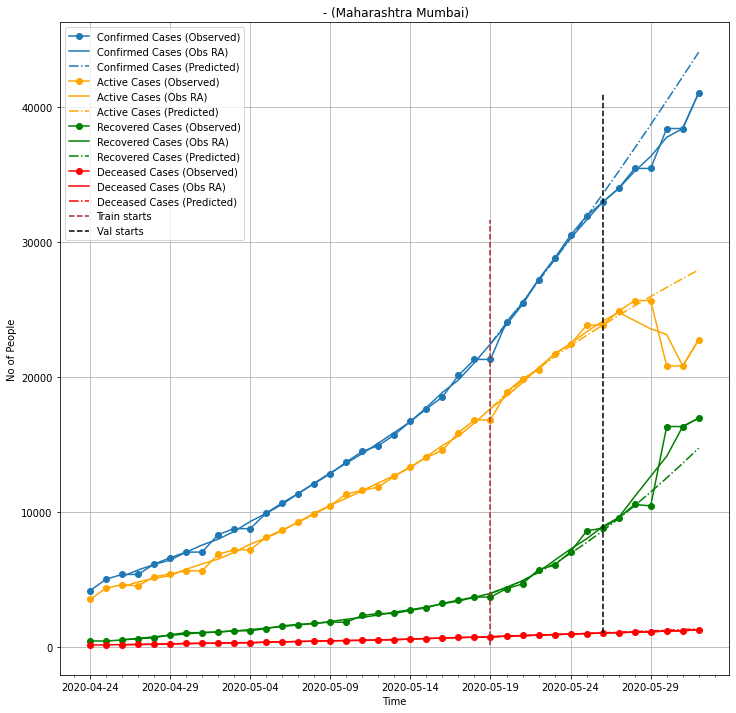

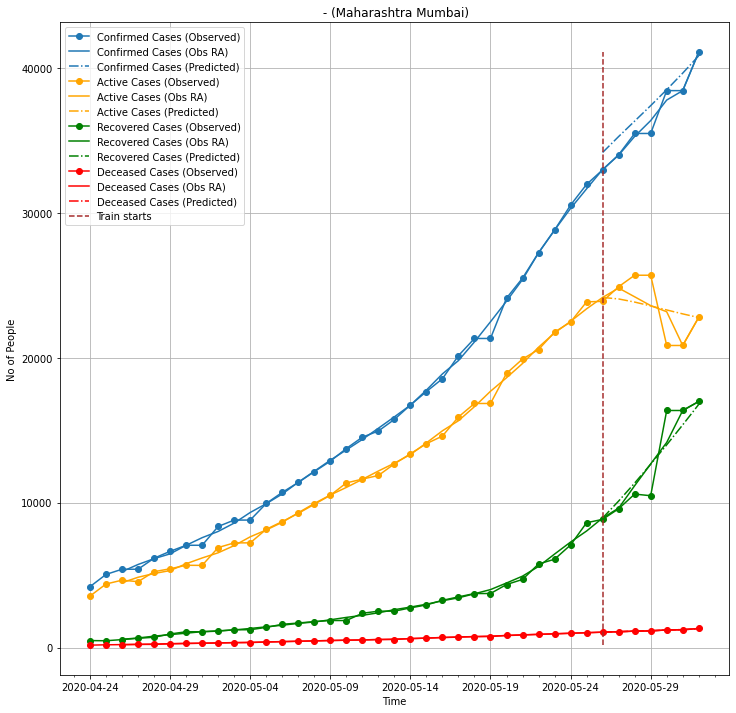

In [14]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = rsingle_fitting_cycle(smoothfunc,
        dataframes, state, district, train_period=7, val_period=7,
        n_days_back_smooth=ndays,
        data_from_tracker=True, initialisation='intermediate', num_evals=700,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = rsingle_fitting_cycle(smoothfunc,
        dataframes, state, district, train_period=7, val_period=0, num_evals=700,
        n_days_back_smooth=ndays,
        train_on_val=True, data_from_tracker=True, initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [ ]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

### M2 Loss

In [ ]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

## Plot Forecasts

In [189]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

getting forecasts ..


KeyError: 'm2'

In [20]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [21]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [22]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))